# Trajectory planning for multi-agent systems

Multi-agent path finding (MAPF) is a problem that has been studied for a large number of years for applications including robotics, aviation, video games, and more [[Dresner and Stone 2008](https://www.jair.org/index.php/jair/article/download/10542/25241),
[Ma et al. 2017](https://ojs.aaai.org/index.php/AIIDE/article/download/12919/12767),
[Pallottino et al. 2007](https://ieeexplore.ieee.org/iel5/8860/4399947/04392815.pdf?casa_token=HP6WWjHKswQAAAAA:ua93qnZ1EBG34GM6r84yNkR5h7uZqYqh3HjF8xB0_zhIMlWwmuI8RMIJ6h-QWElqXOZlSg),
[Silver 2005](https://ojs.aaai.org/index.php/AIIDE/article/download/18726/18503),
[Wurman et al. 2008](http://www.dcsc.tudelft.nl/~sc4081/2018/assign/pap/robert_kiva_paper.pdf)]. It raises the question of how multiple agents can reach their goal position without colliding with each other.

In this case study we are using contracts defined in pacti to ensure that the resulting path is conflict-free. We are focusing on vertex conflicts, where two or more agents cannot share a grid cell, and swapping conflicts, preventing two agents from swapping positions in two adjacent cells. For a detailed survey on objective functions and conflict types, see [[Stern et al. 2019](https://arxiv.org/abs/1906.08291)].

In the following section we will explain the problem setup and illustrate our approach of using contracts to find a safe strategy for the robots. The benefit of using contracts for this application is how modularly we can add/remove robots or additional contraints to the problem.

In the video below you can see the implementation of the resulting strategy for five robots on the
[Robotarium](https://www.robotarium.gatech.edu) [[Wilson et al. 2020](https://ieeexplore.ieee.org/iel7/5488303/8960558/08960572.pdf?casa_token=5GsOySsxPm4AAAAA:gVhO3ngOXJzZ-gnupam3LFl5EDInm50sLy4BTUP8zqxuDvAMRyMKNAp_bPOvBPKmcYbjZg)].

![Robotarium Implementation](https://github.com/FormalSystems/media/blob/main/case_studies/multiagent_coordination/robotarium.gif?raw=true)

This case study shows how Pacti can be used to formalize a multiagent navigation problem and synthesize a strategy for the robots to reach their respective goal position without crashing into each other.

We start by importing the packages and functions that we will need for the analysis.

In [1]:
%matplotlib inline
from pacti.terms.polyhedra import PolyhedralContract
from pacti.iocontract import Var
from utils.multiagent_utils import Coord, Robot, check_collision_quadrants, distance, \
strategy, get_dynamic_collision_contract
from utils.plotting_utils import save_trace, plot_grid_world, animate
import numpy as np

### Create gridworld and robots

First we will create the grid world with the dimensions $n \times m$ for our robots to move in. Each robot starts at their respective initial condition, with the task to reach its goal position on the grid. 
To initialize the robots and set up the grid world, we will call the functions that we imported from multiagent_utils.

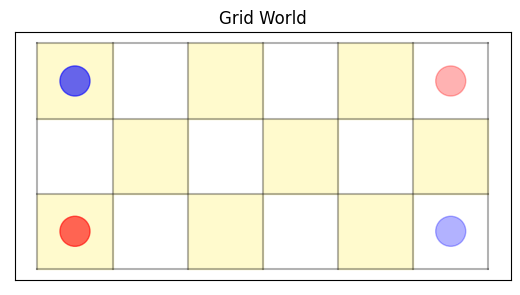

In [2]:
# Define grid world dimensions n x m
n = 6
m = 3

# Initialize robots        
r1 = Robot('A', (0,0), (5,2))
r2 = Robot('B', (0,2), (5,0))
robots = [r1,r2]

plot_grid_world(n,m,robots)

### Define dynamics contracts for each robot per timestep

We will break up the execution into individual timesteps as our planning horizon to reduce the complexity of the planning problem. This horizon length can be increased depending on the problem to be solved, but for the purpose of this case study we will do our planning in increments of single time steps.

The figure below will give an overview of the process per timestep, on the right we will see the resulting traces of the robots when following a strategy found using Pacti.

![Overview Figure](https://github.com/FormalSystems/media/blob/main/case_studies/multiagent_coordination/multiagent_overview.png?raw=true)

This figure shows how we will use the contracts for each time step to place constraints on the movement of the robots. The contracts that we will take into account are $\mathcal{C}_{\text{dyn}}$, which describes the dynamics of each robot,  $\mathcal{C}_{\text{collision}}$, which will ensure that no two robots will occupy the same grid cell, and  $\mathcal{C}_{\text{swapping}}$, which ensure that two robots cannot swap positions (they would collide during the transition). For each time step we will repeat this process and update the positions of the robots according to the chosen move. Applying this strategy will result in a trajectory as shown on the right side of the figure.

Now we define the contracts for the robots' dynamics, the input variables are the current position of each robot in $x$ and $y$ coordinates and the current timestep $t=i$. The output variables are the next position of the robots $(x_{i+1},y_{i+1})$ and the next timestep $i+1$. 

In the assumptions we define the initial positions and time step as the current position of the robot and the current timestep:
$$t_i = t $$
$$x_i = x$$
$$y_i = y$$

The guarantees of the contract are defining the dynamics and ensure that the time step increases by 1.
$$t_{i+1} - t_i = 1$$

The dynamics allow any single cell vertical or horizontal transitions to an adjacent cell on the grid (but not diagonal) and are specified as
$$|x_i - x_{i+1}| + |y_i - y_{i+1}| \leq 1.$$
We will break this constraint up into four separate constraints:
$$x_{i+1} - x_i + y_{i+1} - y_i \leq 1$$
$$x_{i+1} - x_i - y_{i+1} + y_i \leq 1$$
$$-x_{i+1} + x_i + y_{i+1} - y_i \leq 1$$
$$-x_{i+1} + x_i - y_{i+1} + y_i \leq 1$$

We also ensure that the robot has to remain within the grid, specified as:
$$x_{i+1} < n$$
$$y_{i+1} < m$$

Note that we need one dynamics contract for each robot, as the contract can only describe the dynamics for the robot whose behavior it describes. We are extending the input and output variables to include the variables for the other robots and the other contracts that we will use later, but each robot's dynamics contract only specifies the guarantees for its respecive robot's coordinates for the next timestep. In the code the subscript $0$ corresponds to timestep $i$ and the subscript $1$ corresponds to timestep $i+1$.

This contract implementing the constraints explained above is defined in the following function:

In [3]:
def get_dynamics_contract_robot(name, init_pos, timestep): 
    X_str_0 = 'x_'+str(name)+'_0'
    Y_str_0 = 'y_'+str(name)+'_0'
    X_str_1 = 'x_'+str(name)+'_1'
    Y_str_1 = 'y_'+str(name)+'_1'
    t_0 = "t_0"
    t_1 = "t_1"

    contract = PolyhedralContract.from_string(
    input_vars = [X_str_0, Y_str_0, t_0],
    output_vars= [X_str_1, Y_str_1, t_1],
    assumptions=[
      f"{X_str_0} = " + str(init_pos.x),
      f"{Y_str_0} = " + str(init_pos.y),
      f"{t_0} = " + str(timestep),
    ],
    guarantees=[
      f"{t_1} - {t_0} = 1",
      f"{X_str_1} - {X_str_0} + {Y_str_1} - {Y_str_0} <= 1",
      f"{X_str_1} - {X_str_0} - {Y_str_1} + {Y_str_0} <= 1",
      f"-{X_str_1} + {X_str_0} + {Y_str_1} - {Y_str_0} <= 1",
      f"-{X_str_1} + {X_str_0} - {Y_str_1} + {Y_str_0} <= 1",
      f"{X_str_1} <= {n-1}",
      f"{Y_str_1} <= {m-1}",
      f"-{X_str_1} <= 0",
      f"-{Y_str_1} <= 0",
    ]
  )
    return contract

### Methodological implementation of OR by viewpoints
Next we describe the contracts that will ensure that our robots do not collide. For this we will place constraints on the distance between a pair of robots, and ensure that is will always be larger or equal to one cell - meaning two robots will never share the same cell (i.e. collide).

To describe the this requirement in linear inequalities, we need to break up the contract into four smaller contracts. Each contract will place constraints on both robots for a specific configuration with regards to each other (for example robot A is to the top right of robot B). We will refer to these configurations as 'collision quadrants'.

As the guarantees of these contracts are mutually exclusive (robots can only be in one configuration at a time - Robot A cannot be to the right and to the left of robot B at the same time), we need to consider each of these collision quadrants separately in our analysis. This is our methodological implementation of the 'OR' operator of a requirement.

The collision quadrant contracts for two robots $A$ and $B$ are defined as follows.

We assume that the two robots do not collide:
$$\text{distance}(A,B) \geq 1$$

Each collision quadrant enforces one of these guarantees:

$$ x^A_1 - x^B_1 + y^A_1 - y^B_1 \leq -1 $$
$$ x^A_1 - x^B_1 - y^A_1 + y^B_1 \leq -1 $$
$$ x^A_1 + x^B_1 + y^A_1 - y^B_1 \leq -1 $$
$$ x^A_1 + x^B_1 - y^A_1 + y^B_1 \leq -1 $$

We will show the first collision contract and import the remaining contracts from utils.

In [4]:
def collision_quadrant_1():
    
    contract = PolyhedralContract.from_string(
    input_vars = ["t_0", "current_distance"],
    output_vars= ["x_A_1", "y_A_1", "x_B_1", "y_B_1", "t_1"]
                 ,
    assumptions=[
      f"-current_distance <= -1",
    ],
    guarantees=[
      f"x_A_1 - x_B_1 + y_A_1 - y_B_1 <= -1",
    ]
    )
    
    return contract

from utils.contract_utils import collision_quadrant_2, collision_quadrant_3, \
collision_quadrant_4

Now we use Pacti to read in the contracts from the functions and display them to confirm we set them up as desired.

In [5]:
c_dyn1 = get_dynamics_contract_robot(r1.name, r1.pos, 0)
c_dyn2 = get_dynamics_contract_robot(r2.name, r2.pos, 0)
c_q1 = collision_quadrant_1()
c_q2 = collision_quadrant_2()
c_q3 = collision_quadrant_3()
c_q4 = collision_quadrant_4()

print("Contract A:\n" + str(c_dyn1)+'\n')
print("Contract B:\n" + str(c_dyn2)+'\n')

print("Collision Quadrant Q1:\n" + str(c_q1))

Contract A:
InVars: [x_A_0, y_A_0, t_0]
OutVars:[x_A_1, y_A_1, t_1]
A: [
  x_A_0 = 0.0
  y_A_0 = 0.0
  t_0 = 0.0
]
G: [
  -t_0 + t_1 = 1.0
  -x_A_0 + x_A_1 - y_A_0 + y_A_1 <= 1.0
  -x_A_1 <= 0.0
  -y_A_1 <= 0.0
]

Contract B:
InVars: [x_B_0, y_B_0, t_0]
OutVars:[x_B_1, y_B_1, t_1]
A: [
  x_B_0 = 0.0
  y_B_0 = 2.0
  t_0 = 0.0
]
G: [
  -t_0 + t_1 = 1.0
  -x_B_0 + x_B_1 + y_B_0 - y_B_1 <= 1.0
  y_B_1 <= 2.0
  -x_B_1 <= 0.0
]

Collision Quadrant Q1:
InVars: [t_0, current_distance]
OutVars:[x_A_1, y_A_1, x_B_1, y_B_1, t_1]
A: [
  -current_distance <= -1.0
]
G: [
  x_A_1 - x_B_1 + y_A_1 - y_B_1 <= -1.0
]


### Methodologial implementation of OR by transforming variables
Next we define the contract that determines that the robots will also stay collision free during their transition to another cell, meaning that two robots cannot switch places in the grid, as they would collide. We do this by manipulating the $x$ and $y$ coordinates of the two robots as follows:

 $$    \delta x = (x^A_i - x^B_i) * (x^A_{i+1} - x^B_{i+1}) $$
 $$    \delta y = (y^A_i - y^B_i) * (y^A_{i+1} - y^B_{i+1}) $$
 
 $$\delta_x + \delta_y \geq 1$$
 
Of course this contract also assumes no collision.
 
This is the second methodological way to encode an OR in the contract and the contract is defined as follows:

In [6]:
def dynamic_collision_constraints():
    
    contract = PolyhedralContract.from_string(
    input_vars = ["delta_x", "delta_y", "current_distance"],
    output_vars= []
                 ,
    assumptions=[
      f"-current_distance <= -1",
    ],
    guarantees=[
      f"-delta_x - delta_y <= -1",
    ]
    )
    return contract

c_dyn_collision = dynamic_collision_constraints()

print("Dynamic Collision Contract:\n" + str(c_dyn_collision))

Dynamic Collision Contract:
InVars: [delta_x, delta_y, current_distance]
OutVars:[]
A: [
  -current_distance <= -1.0
]
G: [
  -delta_x - delta_y <= -1.0
]


### Merging the contracts
Now we are ready to start merging the contracts. We start by merging the dynamics contracts for each of the robots. This contract now holds all the information for possible steps that both robots can take, but it does not ensure no collisions yet. Now let's take a look at the contract describing the dynamics for both robots.

In [7]:
merged_dyn_contract = c_dyn1.merge(c_dyn2)
print(merged_dyn_contract)

InVars: [x_A_0, y_A_0, t_0, x_B_0, y_B_0]
OutVars:[x_A_1, y_A_1, t_1, x_B_1, y_B_1]
A: [
  x_A_0 = 0.0
  y_A_0 = 0.0
  t_0 = 0.0
  x_B_0 = 0.0
  y_B_0 = 2.0
]
G: [
  -t_0 + t_1 = 1.0
  -x_A_0 + x_A_1 - y_A_0 + y_A_1 <= 1.0
  -x_A_1 <= 0.0
  -y_A_1 <= 0.0
  -x_B_0 + x_B_1 + y_B_0 - y_B_1 <= 1.0
  y_B_1 <= 2.0
  -x_B_1 <= 0.0
]


To ensure that our robots will remain collision-free during the run, we now need to check the solutions that satisfy each of the collision quadrants. We merge each collision quadrant contract with the dynamics contract separately for our analysis. Not all of them will be satisfiable depending on the location of the robots on the grid, we will only consider the satisfiable contracts. Now let's take a look at the contract describing the dynamics for both robots.

In [8]:
# return list of all satisfyable contracts
def check_collision_quadrants(merged_dyn_contract, c_q1, c_q2, c_q3, c_q4):
    merged_contracts = []

    try:
        merged_contract_q1 = merged_dyn_contract.merge(c_q1)
        merged_contracts.append(merged_contract_q1)
    except:
        pass

    try:
        merged_contract_q2 = merged_dyn_contract.merge(c_q2)
        merged_contracts.append(merged_contract_q2)
    except:
        pass

    try:
        merged_contract_q3 = merged_dyn_contract.merge(c_q3)
        merged_contracts.append(merged_contract_q3)
    except:
        pass

    try:
        merged_contract_q4 = merged_dyn_contract.merge(c_q4)
        merged_contracts.append(merged_contract_q4)
    except:
        pass
    return merged_contracts


merged_contracts = check_collision_quadrants(merged_dyn_contract, c_q1, c_q2, c_q3, c_q4)

Now we evaluate each of the merged contracts to find all possible moves that the robots can take which will satisfy our specification. From this list we can implement any desired strategy that will lead the robots to their goal.

In [9]:
def find_move_candidates(r1, r2, T_0, contract, c_dyn_collision):
    
    x_A_0 = Var("x_A_0")
    y_A_0 = Var("y_A_0")
    x_B_0 = Var("x_B_0")
    y_B_0 = Var("y_B_0")
    current_distance = Var("current_distance")
    t_0 = Var("t_0")
    t_1 = Var("t_1")
    x_A_1 = Var("x_A_1")
    y_A_1 = Var("y_A_1")
    x_B_1 = Var("x_B_1")
    y_B_1 = Var("y_B_1")
    delta_x = Var("delta_x")
    delta_y = Var("delta_y")
    
    X_A_0 = r1.pos.x
    Y_A_0 = r1.pos.y
    X_B_0 = r2.pos.x 
    Y_B_0 = r2.pos.y
    cur_dist = np.abs(X_A_0 - X_B_0) + np.abs(Y_A_0 - Y_B_0)

    T_1 = T_0 + 1
    
    # find possible next position [(x,y),(x,y)] options for robots
    possible_sol = []
                    
    for x_a in [max(X_A_0-1,0), X_A_0, min(X_A_0+1,n)]:
        for y_a in [max(Y_A_0-1,0), Y_A_0, min(Y_A_0+1,m)]:
            for x_b in [max(X_B_0-1,0), X_B_0, min(X_B_0+1,n)]:
                for y_b in [max(Y_B_0-1,0), Y_B_0, min(Y_B_0+1,m)]:
                    
                    del_x = (x_a - x_b)*(X_A_0 - X_B_0)
                    del_y = (y_a - y_b)*(Y_A_0 - Y_B_0)
                
                    
                    var_dict = {x_A_0: X_A_0, y_A_0: Y_A_0, x_B_0: X_B_0, \
                               y_B_0: Y_B_0, current_distance: cur_dist, \
                               t_0: T_0, t_1: T_1, x_A_1: x_a, y_A_1: y_a, \
                               x_B_1: x_b, y_B_1: y_b, delta_x: del_x, \
                               delta_y: del_y}
                    
                    if c_dyn_collision.a.contains_behavior(var_dict) and \
                         c_dyn_collision.g.contains_behavior(var_dict) and \
                         contract.a.contains_behavior(var_dict) and \
                         contract.g.contains_behavior(var_dict):
                        
                        possible_sol.append([(x_a,y_a),(x_b,y_b)])
                        
    return possible_sol, t_1

t_0 = 0
sols = []
for i in range(len(merged_contracts)):
    possible_sol, t_1 = find_move_candidates(r1, r2, t_0, merged_contracts[i], \
                                             c_dyn_collision)
    sols = sols + possible_sol

move_candidates = []
for sol in sols:
    if sol not in move_candidates:
        move_candidates.append(sol)
 
# now pick a move and run it again for the next timestep!
move = strategy(move_candidates,(r1.goal,r2.goal))
print('These are the possible positions for the next timestep: ' + str(move_candidates))

print('The chosen move is '+str(move))

These are the possible positions for the next timestep: [[(0, 0), (0, 1)], [(0, 0), (0, 2)], [(0, 0), (1, 2)], [(0, 1), (0, 2)], [(0, 1), (1, 2)], [(1, 0), (0, 2)], [(1, 0), (1, 2)], [(1, 0), (0, 1)]]
The chosen move is [(0, 1), (1, 2)]


Now we can put everything together and run the simulation of our two robots navigating the grid together.

Note: If you do not have `ffmpeg` install, you will need to install it to create the animation (https://www.ffmpeg.org).

In [10]:
r1 = Robot('A', (0,0), (5,2))
r2 = Robot('B', (0,2), (5,0))
trace = []
robots = [r1,r2]

t = 0
trace = save_trace(trace, [(r1.pos.x, r1.pos.y),(r2.pos.x, r2.pos.y)], \
                   [(r1.goal.x, r1.goal.y),(r2.goal.x, r2.goal.y)])

for i in range(0,15):
    c_dyn1 = get_dynamics_contract_robot(r1.name, r1.pos, t)
    c_dyn2 = get_dynamics_contract_robot(r2.name, r2.pos, t)
    merged_dyn_contract = c_dyn1.merge(c_dyn2)
    merged_contracts = check_collision_quadrants(merged_dyn_contract, c_q1, c_q2, \
                                                 c_q3, c_q4)
    
    sols = []
    for i in range(len(merged_contracts)):
        possible_sol, t_1 = find_move_candidates(r1, r2, t, merged_contracts[i], \
                                                 c_dyn_collision)
        sols = sols + possible_sol

    move_candidates = []
    for sol in sols:
        if sol not in move_candidates:
            move_candidates.append(sol)
            
    move = strategy(move_candidates,(r1.goal,r2.goal))
    r1.move(move[0])
    r2.move(move[1])
    
    trace = save_trace(trace, [(r1.pos.x, r1.pos.y),(r2.pos.x, r2.pos.y)], \
                       [(r1.goal.x, r1.goal.y),(r2.goal.x, r2.goal.y)])
    
    if distance([[r1.pos.x, r1.pos.y],[r2.pos.x, r2.pos.y]],[r1.goal,r2.goal]) == 0:
        break;
#     t = t_1
        
animate(trace, n, m, '2_robots')

Rendering 16 frames...


This is how to set up a multi-agent navigation problem in Pacti with a horizon of a single timestep, if desired this horizon can be extended by composing multiple timesteps to ensure that the robots will not get stuck depending on the obstacle placement and the actions that the robots are taking. For this case study we will continue using a horizon length of one but we will increase the number of robots in our grid world.

### Extension to three robots

In [11]:
from utils.multiagent_utils import strategy_multiple, find_move_candidates_multiple,\
    get_possible_moves_multiple_robots, get_collision_contracts_robot_pair

# set grid world dimensions n x m
n = 5
m = 5

# Intitialize the robots
r1 = Robot('A', (0,0), (4,4))
r2 = Robot('B', (0,2), (4,2))
r3 = Robot('C', (0,4), (4,0))
robots = [r1,r2,r3]

# Get the collision contracts
collision_AB = get_collision_contracts_robot_pair('A', 'B', 'C')
collision_AC = get_collision_contracts_robot_pair('A', 'C', 'B')
collision_BC = get_collision_contracts_robot_pair('B', 'C', 'A')
collision_contracts = [collision_AB, collision_AC, collision_BC]
c_dyn_collision = get_dynamic_collision_contract(robots)

t = 0
trace = []
trace = save_trace(trace, [(r1.pos.x, r1.pos.y),(r2.pos.x, r2.pos.y),(r3.pos.x, r3.pos.y)],\
                   [(r1.goal.x, r1.goal.y),(r2.goal.x, r2.goal.y),(r3.goal.x, r3.goal.y)])
last_pos = None

for i in range(0,30):
    c_dyn1 = get_dynamics_contract_robot(r1.name, r1.pos, t)
    c_dyn2 = get_dynamics_contract_robot(r2.name, r2.pos, t)
    c_dyn3 = get_dynamics_contract_robot(r3.name, r3.pos, t)
    
    merged_dyn_contract_1_2 = c_dyn1.merge(c_dyn2)
    merged_dyn_contract = merged_dyn_contract_1_2.merge(c_dyn3)
    
    moves_list = get_possible_moves_multiple_robots(n,m,robots, merged_dyn_contract, \
                                                    collision_contracts, c_dyn_collision)
    
    goals = (r1.goal,r2.goal,r3.goal)
    cur_pos = (r1.pos.x, r1.pos.y),(r2.pos.x, r2.pos.y),(r3.pos.x, r3.pos.y)
    cur_dist = distance(cur_pos,goals)

    move = strategy_multiple(moves_list, goals, cur_pos, last_pos)
    last_pos = cur_pos
    
    r1.move(move[0])
    r2.move(move[1])
    r3.move(move[2])
    
    trace = save_trace(trace, [(r1.pos.x, r1.pos.y),(r2.pos.x, r2.pos.y),\
                              (r3.pos.x, r3.pos.y)], [(r1.goal.x, r1.goal.y),\
                              (r2.goal.x, r2.goal.y), (r3.goal.x, r3.goal.y)])
    
    if distance([[r1.pos.x, r1.pos.y],[r2.pos.x, r2.pos.y],[r3.pos.x, r3.pos.y]],\
                [r1.goal,r2.goal, r3.goal]) == 0:
        break;
        
animate(trace, n, m, '3_robots')

Rendering 13 frames...


This analysis can be extended by adding obstacles (by adding a contract that ensures no collision with obstacles) and adding more robots to the grid as desired. 
We showed how to set up our contracts to describe the viewpoint for a single timestep, and how to modularly add contracts describing the dynamics of individual robots and conflicts.

Depending on the obstacle geometry and the number of robots, it may be necessary to consider a longer horizon to reach the goal more efficiently - prevent situations where the robots get stuck. For this we could compose the contracts for multiple timesteps and pick the strategy on the possible action set resulting from this analysis, which we leave to future work.

## References

[**Dresner and Stone 2008**](https://www.jair.org/index.php/jair/article/download/10542/25241)

Dresner, K. and Stone, P., 2008. A multiagent approach to autonomous intersection management. Journal of artificial intelligence research, 31, pp.591-656.

[**Ma et al. 2017**](https://ojs.aaai.org/index.php/AIIDE/article/download/12919/12767)

Ma, H., Yang, J., Cohen, L., Kumar, T.S. and Koenig, S., 2017, September. Feasibility study: Moving non-homogeneous teams in congested video game environments. In Thirteenth Artificial Intelligence and Interactive Digital Entertainment Conference.

[**Pallottino et al. 2007**](https://ieeexplore.ieee.org/iel5/8860/4399947/04392815.pdf?casa_token=HP6WWjHKswQAAAAA:ua93qnZ1EBG34GM6r84yNkR5h7uZqYqh3HjF8xB0_zhIMlWwmuI8RMIJ6h-QWElqXOZlSg)

Pallottino, L., Scordio, V.G., Bicchi, A. and Frazzoli, E., 2007. Decentralized cooperative policy for conflict resolution in multivehicle systems. IEEE Transactions on Robotics, 23(6), pp.1170-1183.

[**Silver 2005**](https://ojs.aaai.org/index.php/AIIDE/article/download/18726/18503)

Silver, D., 2005. Cooperative pathfinding. In Proceedings of the aaai conference on artificial intelligence and interactive digital entertainment (Vol. 1, No. 1, pp. 117-122).

[**Stern et al. 2019**](https://arxiv.org/abs/1906.08291)

Stern, R., Sturtevant, N.R., Felner, A., Koenig, S., Ma, H., Walker, T.T., Li, J., Atzmon, D., Cohen, L., Kumar, T.S. and Barták, R., 2019, July. _Multi-agent pathfinding: Definitions, variants, and benchmarks._ In Twelfth Annual Symposium on Combinatorial Search.

[**Wilson et al. 2020**](https://ieeexplore.ieee.org/iel7/5488303/8960558/08960572.pdf?casa_token=5GsOySsxPm4AAAAA:gVhO3ngOXJzZ-gnupam3LFl5EDInm50sLy4BTUP8zqxuDvAMRyMKNAp_bPOvBPKmcYbjZg)

Wilson, S., Glotfelter, P., Wang, L., Mayya, S., Notomista, G., Mote, M. and Egerstedt, M., 2020. The robotarium: Globally impactful opportunities, challenges, and lessons learned in remote-access, distributed control of multirobot systems. IEEE Control Systems Magazine, 40(1), pp.26-44.

[**Wurman et al. 2008**](http://www.dcsc.tudelft.nl/~sc4081/2018/assign/pap/robert_kiva_paper.pdf)

Wurman, P.R., D'Andrea, R. and Mountz, M., 2008. Coordinating hundreds of cooperative, autonomous vehicles in warehouses. AI magazine, 29(1), pp.9-9.

